<a href="https://colab.research.google.com/github/hieu1999210/Insincere-question-classification/blob/master/group_Relu_Elmo_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install h5py pyyaml
# !pip install tf_nightly

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.14.0'

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

### Load and preprocess data

In [1]:
# mount hieu.kaggle

from google.colab import drive
drive.mount('/gdrive', force_remount=False)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
cd "/gdrive/My Drive/nlp"

/gdrive/My Drive/nlp


In [3]:
!ls

data  embeddings  training_elmo


In [0]:
# Load data

path_train = "data/train.csv"
path_test = "data/test.csv"
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)
# Dataset is now stored in a Pandas Dataframe

In [0]:
train, val = train_test_split(train, test_size = 0.01, random_state = 2019) 

In [0]:
#@title Some parameters
embedding_dim = 1024 #@param {type:"integer"}

vocab_size = 50000 #@param {type:"integer"}

question_length = 100 #@param {type:"integer"}

batch_size = 256 #@param {type:"integer"}


In [0]:
## fill up the missing values
train_X = train["question_text"].fillna("_na_").values
val_X = val["question_text"].fillna("_na_").values
test_X = test["question_text"].fillna("_na_").values

#Tokenize the sentences
# tokenizer = Tokenizer(num_words = max_features)
# tokenizer.fit_on_texts(list(train_X))
# train_X = tokenizer.texts_to_sequences(train_X)
# val_X = tokenizer.texts_to_sequences(val_X)
# test_X = tokenizer.texts_to_sequences(test_X)

In [0]:
# #padding
# train_X = pad_sequences(train_X, maxlen = maxlen)
# val_X = pad_sequences(val_X, maxlen = maxlen)
# test_X = pad_sequences(test_X, maxlen = maxlen)

In [0]:
train_y = train['target'].values
val_y = val['target'].values

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

In [0]:
#padding

from keras.preprocessing.text import text_to_word_sequence

def padding(sentences, maxlen= question_length, pad_word = ""):
    """
    padding sentences and truncating if necessary
    """
    Sentences = [text_to_word_sequence(sentence, lower = False, split=' ') for sentence in sentences]
#     lengths = []
    for i, sentence in enumerate(Sentences):
#         lengths.append(len(sentence))
        if len(sentence) > maxlen:
            Sentences[i] = sentence[:maxlen]
        else:
            for _ in range(maxlen - len(sentence)):
                sentence.append(pad_word)
    return Sentences

train_X = padding(train_X)
val_X = padding(val_X)

In [0]:
# to run on tpu


# def train_input_fn(x_train=train_X, y_train=train_y, batch_size=batch_size):
#     # Convert the inputs to a Dataset.
#     dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
# # Shuffle, repeat, and batch the examples.
#     dataset = dataset.cache()
#     dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
#     dataset = dataset.repeat()
#     dataset = dataset.batch(batch_size, drop_remainder=True)
# # Return the dataset.
#     return dataset

In [0]:
# tpu_val = train_input_fn(val_X, val_y)

In [0]:
# tpu_train = train_input_fn(train_X, train_y)

In [0]:
# test padding
count = 0
for sentence in val_X:
    if len(sentence) != 100:
        count +=1
count

0

In [0]:
# to enable  tpu


# import sys

# # sys.path.append('bert/')

# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

# import codecs
# import collections
# import json
# import re
# import os
# import pprint
# import numpy as np
# import tensorflow as tf

# assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
# TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# print('TPU address is', TPU_ADDRESS)

# from google.colab import auth
# auth.authenticate_user()
# with tf.Session(TPU_ADDRESS) as session:
#   print('TPU devices:')
#   pprint.pprint(session.list_devices())

#   # Upload credentials to TPU.
#   with open('/content/adc.json', 'r') as f:
#     auth_info = json.load(f)
#   tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
#   # Now credentials are set for all future sessions on this TPU.

## Build model

import elmo 


In [0]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=False)

In [0]:
sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())


In [0]:

def ElmoEmbedding(x):
    return elmo(inputs={"tokens": tf.squeeze(tf.cast(x,tf.string)),
                        "sequence_len": tf.constant(batch_size*[question_length])},
                signature="tokens",
                as_dict=True)["elmo"]

In [0]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(y_true * y_pred)
        possible_positives = K.sum(y_true)
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(y_true * y_pred)
        predicted_positives = K.sum(y_pred)
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    Y_pred = tf.cast(tf.less(0.3, y_pred), tf.float32)
    
    precision = precision(y_true, Y_pred)
    recall = recall(y_true, Y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
print(tf.keras.__version__)


2.2.4-tf


In [19]:
from keras.models import Sequential
from keras.layers import Dense,Lambda, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

def build_model ():
# model = Sequential()
# model.add(Lambda(ElmoEmbedding, output_shape = (1024, )))
# #model.add(Embedding(50000, 300, input_length=100, trainable=True))
# model.add(Dropout(0.2))
# model.add(Conv1D(64, 5, activation='relu'))
# model.add(MaxPooling1D(pool_size=4))
# model.add(LSTM(300))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.build(input_shape = (None, 100, 1024))
# model.summary()


  input_text = Input(shape=(question_length,) , dtype = tf.string)
  embedding = Lambda(ElmoEmbedding, output_shape=(question_length, embedding_dim))(input_text)
  x = Dropout(rate = 0.2)(embedding)
  x = Conv1D(64, 5, activation = 'relu')(x)
  x = MaxPooling1D(pool_size = 4)(x)
  x = LSTM(units = 300)(x)
  x = Dense(1, activation = 'sigmoid')(x)
  model = Model(inputs = input_text, outputs = x)
  model.compile(optimizer='adam', loss="binary_crossentropy", metrics = [f1])

  return model

model = build_model()
model.summary()

  


W0710 14:36:58.430854 140009667860352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 14:36:58.433212 140009667860352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 14:37:00.660320 140009667860352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0710 14:37:00.673707 140009667860352 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a futur

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 1024)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 1024)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            327744    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               438000    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total para

In [0]:
# resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
# tf.contrib.distribute.initialize_tpu_system(resolver)
# strategy = tf.contrib.distribute.TPUStrategy(resolver)


# with strategy.scope():
# #   model = get_model()
#   model.compile(optimizer=opt, 
#                 loss="binary_crossentropy", 
#                 metrics = [f1])

# model.summary()

#Train model

In [0]:
class Batch_Generator:
    def __init__(self, trainX, trainY, valX, valY, batch_size = batch_size,
                 testX=None, testY=None,shuffle=True):
        self.X = {
            'train': trainX,
            'val': valX,
            'test': testX
        }
        self.Y = {
            'train': trainY,
            'val': valY,
            'test': testY
        }
        self.cur_idx = {
            'train': 0,
            'val': 0,
            'test': 0
        }
        self.shuffle = shuffle
    def next_batch(self, mode):
        n_samples = len(self.X[mode])
        if self.shuffle==True:
            indices = np.random.permutation(n_samples)
        else:
            indices = range(n_samples)
        while True:
            if self.cur_idx[mode] >= (n_samples - batch_size):
                if self.shuffle == True:
                    indices = np.random.permutation(n_samples)
                self.cur_idx[mode] = 0
                
            x_list = []
            y_list = []
            batch_end = self.cur_idx[mode] + batch_size
            for i in indices[self.cur_idx[mode]:batch_end]:
                x_list.append(self.X[mode][i])
                y_list.append(self.Y[mode][i])

            self.cur_idx[mode] += batch_size
            yield np.array(x_list), np.array(y_list)


In [21]:
checkpoint_path = "training_elmo/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # Save weights, every 5-epochs.
    period=10)
# model.save_weights(checkpoint_path.format(epoch=0))

W0710 14:37:15.184892 140009667860352 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [0]:

generator = Batch_Generator(train_X, train_y, val_X, val_y)
history = model.fit_generator(generator=generator.next_batch('train'), 
                    steps_per_epoch=50,
                    epochs=100,
                    verbose=1,
                    callbacks=[cp_callback],
                    validation_data=generator.next_batch('val'),
                    validation_steps=1)


Epoch 1/100
50/50 [==============================] - 235s 5s/step - loss: 0.1328 - f1: 0.5471 - val_loss: 0.1805 - val_f1: 0.4583
Epoch 2/100
50/50 [==============================] - 234s 5s/step - loss: 0.1255 - f1: 0.5586 - val_loss: 0.1008 - val_f1: 0.6429
Epoch 3/100
50/50 [==============================] - 234s 5s/step - loss: 0.1277 - f1: 0.6015 - val_loss: 0.1332 - val_f1: 0.4000
Epoch 4/100
50/50 [==============================] - 234s 5s/step - loss: 0.1181 - f1: 0.5880 - val_loss: 0.1490 - val_f1: 0.6486
Epoch 5/100
50/50 [==============================] - 234s 5s/step - loss: 0.1283 - f1: 0.5756 - val_loss: 0.1191 - val_f1: 0.6667
Epoch 6/100
50/50 [==============================] - 235s 5s/step - loss: 0.1252 - f1: 0.5670 - val_loss: 0.0938 - val_f1: 0.6667
Epoch 7/100
50/50 [==============================] - 235s 5s/step - loss: 0.1173 - f1: 0.5896 - val_loss: 0.1390 - val_f1: 0.1176
Epoch 8/100
50/50 [==============================] - 234s 5s/step - loss: 0.1168 - f1: 0.5

KeyboardInterrupt: ignored

In [0]:
model.load_weights("training_elmo/cp-0050.ckpt")

In [0]:
val_y.shape
13062/256

51.0234375

## Evaluation

In [0]:
generator2 = Batch_Generator(trainX=None, trainY=None, valX=val_X, valY=val_y, shuffle=False)

In [24]:
predict_val_y = model.predict_generator(generator2.next_batch('val'), steps=50, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)


50/50 [==============================] - 229s 5s/step


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


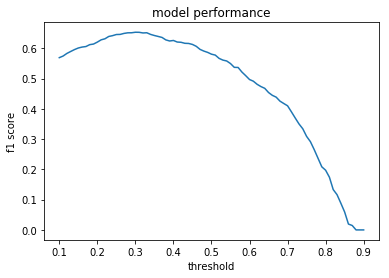

Best F1 score: 0.6528 (thresshold  0.30)


In [27]:
import matplotlib.pyplot as plt

scores = []
thresholds = np.arange(0.1, 0.901, 0.01)

for thresh in thresholds:
    thresh = np.round(thresh, 2)
    score = metrics.f1_score(val_y[:12800], (predict_val_y>thresh).astype(int))
    scores.append(score)
#     print("F1 score at threshold {0} is {1}".format(thresh, score))

plt.plot(thresholds, scores)
# plt.plot(history.history['val_f1'])
plt.title('model performance')
plt.ylabel('f1 score')
plt.xlabel('threshold')
# plt.legend(['train','val'], loc='upper left')

plt.show()
print("Best F1 score: {b:.4f} (thresshold {a: .2f})".format(b=max(scores), 
      a=thresholds[scores.index(max(scores))]))

# f1_list = []
# for thresh in np.arange(0.1, 0.901, 0.01):
#     thresh = np.round(thresh, 2)
#     f1 = metrics.f1_score(val_y[:12800], (predict_val_y>thresh).astype(int))
#     f1_list.append(f1)
# #     print("F1 score at threshold {0} is {1}".format(thresh, f1))
    
# print("max f1: ", max(f1_list))